<a href="https://colab.research.google.com/github/ioana0901/Sentiment-Analysis-on-Short-Texts-The-Case-of-the-Romanian-Language/blob/main/DistilBert_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install import_ipynb
!pip install transformers


In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Analiza sentimentelor umane a textelor din Limba Română"

Mounted at /content/drive
/content/drive/MyDrive/Analiza sentimentelor umane a textelor din Limba Română


In [4]:
import import_ipynb
from FunctionsList import *
import pandas as pd
import numpy as np
import random
import gensim
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from keras import Model
from keras.preprocessing.text import Tokenizer
from keras import regularizers, callbacks
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.initializers import GlorotNormal
from keras.layers import Dense, Dropout, Input

from transformers import AutoTokenizer, AutoModel, DistilBertTokenizerFast, TFDistilBertModel, DistilBertConfig,AdamW
import torch
import torch.nn as nn

importing Jupyter notebook from FunctionsList.ipynb


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
#import data:
data = pd.read_csv('Data/CleanDataset_3Classes_NoStemming_Accents.csv')
#sterge prima coloana
data = data.iloc[: , 1:]
data.head()

,label,review_content
0,1,incarcator românia adaptor cutie trebuie mamei...
1,0,probleme mari semnalul luni achizitionare afis...
2,1,telefon destul ok având vedere android go lejer
3,2,utilizator iphone incepand upgrade iphone ok n...
4,2,cumparat varianta gb gb ram culoare gri nu fol...


### Impartirea setului de date

In [6]:
# imparte setul de date: 80% - 20% 
contents = data['review_content']
labels = data['label']
x_train, x_test, y_train, y_test = train_test_split(contents, labels, train_size=0.8, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, random_state=42)

In [7]:
#one-hot encode labels
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)

print("y_train.shape:", y_train.shape)
print("y_test.shape :", y_test.shape)
print("y_val.shape :", y_val.shape)

y_train.shape: (10965, 3)
y_test.shape : (3225, 3)
y_val.shape : (1935, 3)


### Tokenizare

In [8]:
# incarcarea tokenizer-ului
model_name = "racai/distilbert-base-romanian-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/245k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419 [00:00<?, ?B/s]

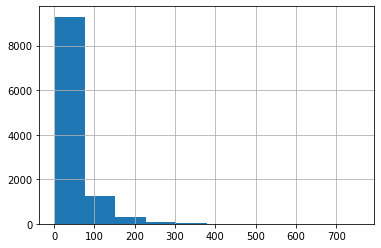

In [9]:
# vezi lungimile textelor
seq_len = [len(i.split()) for i in x_train]
pd.Series(seq_len).hist(bins = 10)

In [10]:
#codifica datele in loturi - ia tokenizer, texts, batch_size, maxlen => returneaza input_ids si attention_mask
maxlen= 300

def batch_encode(tokenizer, texts, batch_size=256, max_length=maxlen):    
    input_ids = []
    attention_mask = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=maxlen,
                                             padding='max_length', 
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False)
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
   # return tf.stack(input_ids), tf.stack(attention_mask)
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

#encode:
x_train_ids, x_train_attention = batch_encode(tokenizer, x_train.tolist())
x_val_ids, x_val_attention = batch_encode(tokenizer, x_val.tolist())
x_test_ids, x_test_attention = batch_encode(tokenizer, x_test.tolist())

In [11]:
type(x_train_attention)

tensorflow.python.framework.ops.EagerTensor

### Incarcarea  modelului pre-antrenat distilBERT si crearea modelului

In [12]:
#defineste modelul
from transformers import TFDistilBertModel, DistilBertConfig

dropout = 0.2
attention_dropout = 0.2
 
# configuratia modelului initiala
config = DistilBertConfig(dropout=dropout, 
                          attention_dropout=attention_dropout,
                          output_hidden_states=True)
                          
# modelul fara cap de clasificare 
distilBERT = TFDistilBertModel.from_pretrained(model_name,config,output_attentions=True)

# seteaza trainable pe False pentru a opri antrenarea - pentru ca ponderile preinstruite ale DistilBERT vor servi ca baza pentru model
# dorim sa le conservam si sa impiedicam actualizarea lor in timpul etapelor initiale de instruire
for layer in distilBERT.layers:
    layer.trainable = False
    
#mai ramane de adaugat capul de clasificare in timpul procesului de ajustare pentru a ajuta modelul sa faca distinctia intre recenzii.


Downloading:   0%|          | 0.00/288M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDistilBertModel.

All the layers of TFDistilBertModel were initialized from the model checkpoint at racai/distilbert-base-romanian-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [13]:
# adauga capul de clasificare
dropout = 0.2
random_state = 42
 
def build_model(transformer, lr, max_length=maxlen): #ia transformatorul initializa (modelul distilbert) si maxlen(max tokens encoded) 
                                                    # => returneaza modelul cu stratul de clasificare    
    #pentru reproductibilitate
    weight_initializer = GlorotNormal(seed=random_state) 

    #straturile de intrare
    input_ids_layer = Input(shape=(max_length,),
                            name='input_ids',
                            dtype='int32')
    input_attention_layer = Input(shape=(max_length,),
                                  name='input_attention',
                                  dtype='int32')
    
    # DistilBERT produce o tupla in care primul element de la indicele 0 - reprezintă starea ascunsa (hidden state) la iesirea din ultimul strat al modelului.
    # Este un tensor de forma (batch_size, sequence_length, hidden_size=768).
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    
    # ne intereseaza doar rezultatul DistilBERT pentru simbolul [CLS], 
    # care se afla la indexul 0 al fiecarei secvente codificate.  
    cls_token = last_hidden_state[:, 0, :]
    
    output = Dense(3,activation='softmax',
                   kernel_initializer=weight_initializer,
                   bias_initializer='zeros')(cls_token)

    # definirea modelului
    model = Model([input_ids_layer, input_attention_layer], output)
    # compilare
    model.compile(Adam(learning_rate=lr), #distilbert-ro-used values
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    return model

In [14]:
x_train_ids.shape

TensorShape([10965, 300])

In [ ]:
tf.keras.utils.plot_model(bmodel, show_shapes=True, dpi=48)

In [ ]:
bmodel.summary()

In [20]:
# un lr mai mic ar putea crește posibilitatea de a ajunge la overfitting
lr=1e-4
epochs = 25
batch_size = 16
steps = len(x_train.index) // batch_size

bmodel_1 = build_model(distilBERT, lr)
# Train the model
history = bmodel_1.fit(x=[x_train_ids, x_train_attention], 
                     y= y_train,
                     epochs = epochs,
                     batch_size = batch_size,
                     steps_per_epoch = steps,
                     validation_data = ([x_val_ids, x_val_attention], y_val))

Epoch 1/25
685/685 [==============================] - 165s 231ms/step - loss: 1.1099 - acc: 0.4807 - val_loss: 0.9519 - val_acc: 0.5871
Epoch 2/25
685/685 [==============================] - 153s 224ms/step - loss: 0.9164 - acc: 0.5983 - val_loss: 0.8921 - val_acc: 0.6134
Epoch 3/25
685/685 [==============================] - 153s 224ms/step - loss: 0.8706 - acc: 0.6233 - val_loss: 0.8592 - val_acc: 0.6362
Epoch 4/25
685/685 [==============================] - 153s 223ms/step - loss: 0.8429 - acc: 0.6398 - val_loss: 0.8389 - val_acc: 0.6475
Epoch 5/25
685/685 [==============================] - 153s 224ms/step - loss: 0.8240 - acc: 0.6446 - val_loss: 0.8211 - val_acc: 0.6512
Epoch 6/25
685/685 [==============================] - 153s 224ms/step - loss: 0.8072 - acc: 0.6495 - val_loss: 0.8081 - val_acc: 0.6506
Epoch 7/25
685/685 [==============================] - 153s 223ms/step - loss: 0.7969 - acc: 0.6531 - val_loss: 0.7974 - val_acc: 0.6589
Epoch 8/25
685/685 [============================

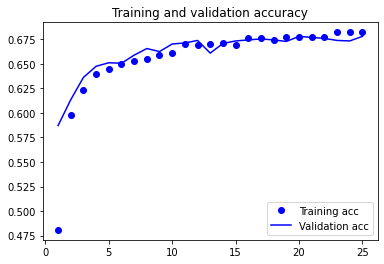

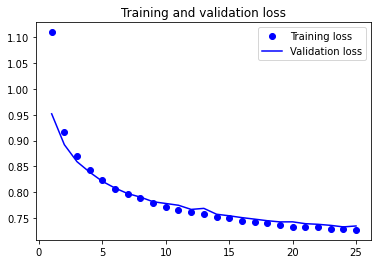

In [21]:
plot_graphs(history)

In [22]:
bmodel_1.evaluate([x_test_ids, x_test_attention],y_test)

101/101 [==============================] - 36s 356ms/step - loss: 0.7300 - acc: 0.6710


[0.7299665212631226, 0.6710077524185181]

In [23]:
pred=bmodel_1.predict([x_test_ids, x_test_attention])
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 37s 353ms/step
              precision    recall  f1-score   support

         neg       0.62      0.69      0.65       937
           n       0.61      0.66      0.63      1025
         pos       0.79      0.66      0.72      1263

    accuracy                           0.67      3225
   macro avg       0.67      0.67      0.67      3225
weighted avg       0.68      0.67      0.67      3225



In [24]:
# incearc alt lr și creste numarul de epoci
lr=5e-5
epochs = 30

bmodel_1 = build_model(distilBERT, lr)
# Train the model
history = bmodel_1.fit(x=[x_train_ids, x_train_attention], 
                     y= y_train,
                     epochs = epochs,
                     batch_size = batch_size,
                     steps_per_epoch = steps,
                     validation_data = ([x_val_ids, x_val_attention], y_val))

Epoch 1/30
685/685 [==============================] - 164s 228ms/step - loss: 1.0831 - acc: 0.4770 - val_loss: 0.9989 - val_acc: 0.5313
Epoch 2/30
685/685 [==============================] - 153s 224ms/step - loss: 0.9641 - acc: 0.5688 - val_loss: 0.9398 - val_acc: 0.5871
Epoch 3/30
685/685 [==============================] - 153s 223ms/step - loss: 0.9189 - acc: 0.6019 - val_loss: 0.9047 - val_acc: 0.6062
Epoch 4/30
685/685 [==============================] - 153s 224ms/step - loss: 0.8897 - acc: 0.6164 - val_loss: 0.8817 - val_acc: 0.6160
Epoch 5/30
685/685 [==============================] - 153s 224ms/step - loss: 0.8691 - acc: 0.6233 - val_loss: 0.8644 - val_acc: 0.6238
Epoch 6/30
685/685 [==============================] - 153s 223ms/step - loss: 0.8538 - acc: 0.6328 - val_loss: 0.8509 - val_acc: 0.6357
Epoch 7/30
685/685 [==============================] - 153s 224ms/step - loss: 0.8418 - acc: 0.6376 - val_loss: 0.8386 - val_acc: 0.6460
Epoch 8/30
685/685 [============================

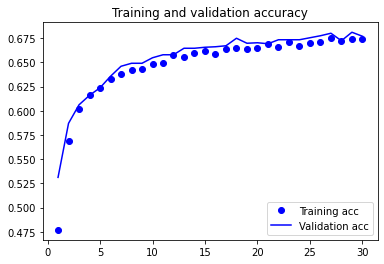

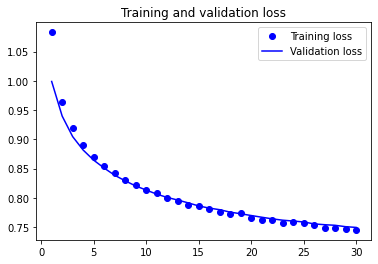

In [25]:
plot_graphs(history)

In [26]:
bmodel_1.evaluate([x_test_ids, x_test_attention], y_test)

101/101 [==============================] - 35s 344ms/step - loss: 0.7483 - acc: 0.6707


[0.7482531666755676, 0.6706976890563965]

In [27]:
pred=bmodel_1.predict([x_test_ids, x_test_attention])
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 36s 345ms/step
              precision    recall  f1-score   support

         neg       0.61      0.68      0.64       947
           n       0.57      0.71      0.63       891
         pos       0.84      0.64      0.73      1387

    accuracy                           0.67      3225
   macro avg       0.67      0.68      0.67      3225
weighted avg       0.70      0.67      0.68      3225

